In [99]:
import numpy as np
import matplotlib.pyplot as plt
import oracles
import plot_trajectory_2d
import optimization
import scipy
from tqdm.notebook import tqdm
import pandas as pd

## Задача логистической регрессии


#### Формулировка
Коэффициенты x являются параметрами модели и настраиваются с помощью решения следующей
оптимизационной задачи:

$$\min_{x \in \mathbb{R^n}} \frac{1}{m} \sum_{i=1}^{m} ln(1 + exp(-b_i \langle\,a_i , x\rangle)) + \frac{\lambda}{2}||x||^2_2 \\
\min_{x \in \mathbb{R^n}} \frac{1}{m} \sum_{i=1}^{m} -ln(\sigma(b_i x^T a_i) + \frac{\lambda}{2}||x||^2_2 \\
\min_{x \in \mathbb{R^n}} \frac{\langle\,-ln(\sigma(Ax \odot b), 1_n \rangle}{m} + \frac{\lambda}{2}||x||^2_2
$$

Где $\odot$ - поэлементное произведение, $1_n = (1, ..., 1), \sigma(x) = \frac{1}{1 + exp(-x)}$

#### Градиент

Положим  $$I(x) := \frac{1}{m} \sum_{i=1}^{m} -ln(\sigma(b_i x^T a_i) + \frac{\lambda}{2}||x||^2_2$$
$$I_i(x) := ln(\sigma(b_i x^T a_i), z_i := b_i x^T a_i \\
\frac{\partial I_i}{\partial x} = \frac{1}{\sigma(z_i)} \frac{\partial \sigma(z_i)}{\partial x} = (1 - \sigma(z_i))\frac{\partial z_i}{\partial x} = (1 - \sigma(z_i))b_i a_i
$$

Отсюда:
$$\nabla I(x) = \frac{1}{m} \sum_{i=1}^m -(1 - \sigma(z_i))b_i a_i + \lambda x \\
\nabla I(x) = A^T(-(1_n - \sigma(b \odot Ax)) \odot b) + \lambda x
$$


####  Гессиан
$$ \frac{\partial \nabla I_i(x)}{\partial x^T} = \frac{\partial (1 - \sigma(z_i))b_i a_i}{\partial x^T} = \\
\frac{\partial \sigma(z_i)b_i a_i}{\partial x^T} = \sigma(z_i)(1 - \sigma(z_i)) \frac{\partial z_i}{\partial x^T} b_i a_i = \sigma(z_i)(1 - \sigma(z_i)) b_i^2 a_i^T a_i \\
\nabla^2 I(x) = \frac{1}{m} \sum_{i=1}^{m} \sigma(z_i)(1 - \sigma(z_i)) b_i^2 a_i^T a_i + \lambda I_n = 
\frac{A^T S_n A}{m} + \lambda I_n
$$, где 
$S_n = (\sigma(b \odot Ax)(1 - \sigma(b \odot Ax)) \odot b^2)$

## Траектория градиентного спуска на квадратичной функции

In [78]:
def create_param_dict(method, c=None, c1=None, c2=None, alpha_0=None):
    param_dict = dict()
    param_dict['method'] = method
    if c is not None:
        param_dict['c'] = c
    else:
        param_dict['c'] = 0.1
    if c1 is not None:
        param_dict['c1'] = c1
    if c2 is not None:
        param_dict['c2'] = c2
    if alpha_0 is not None:
        param_dict['alpha_0'] = alpha_0
    return param_dict

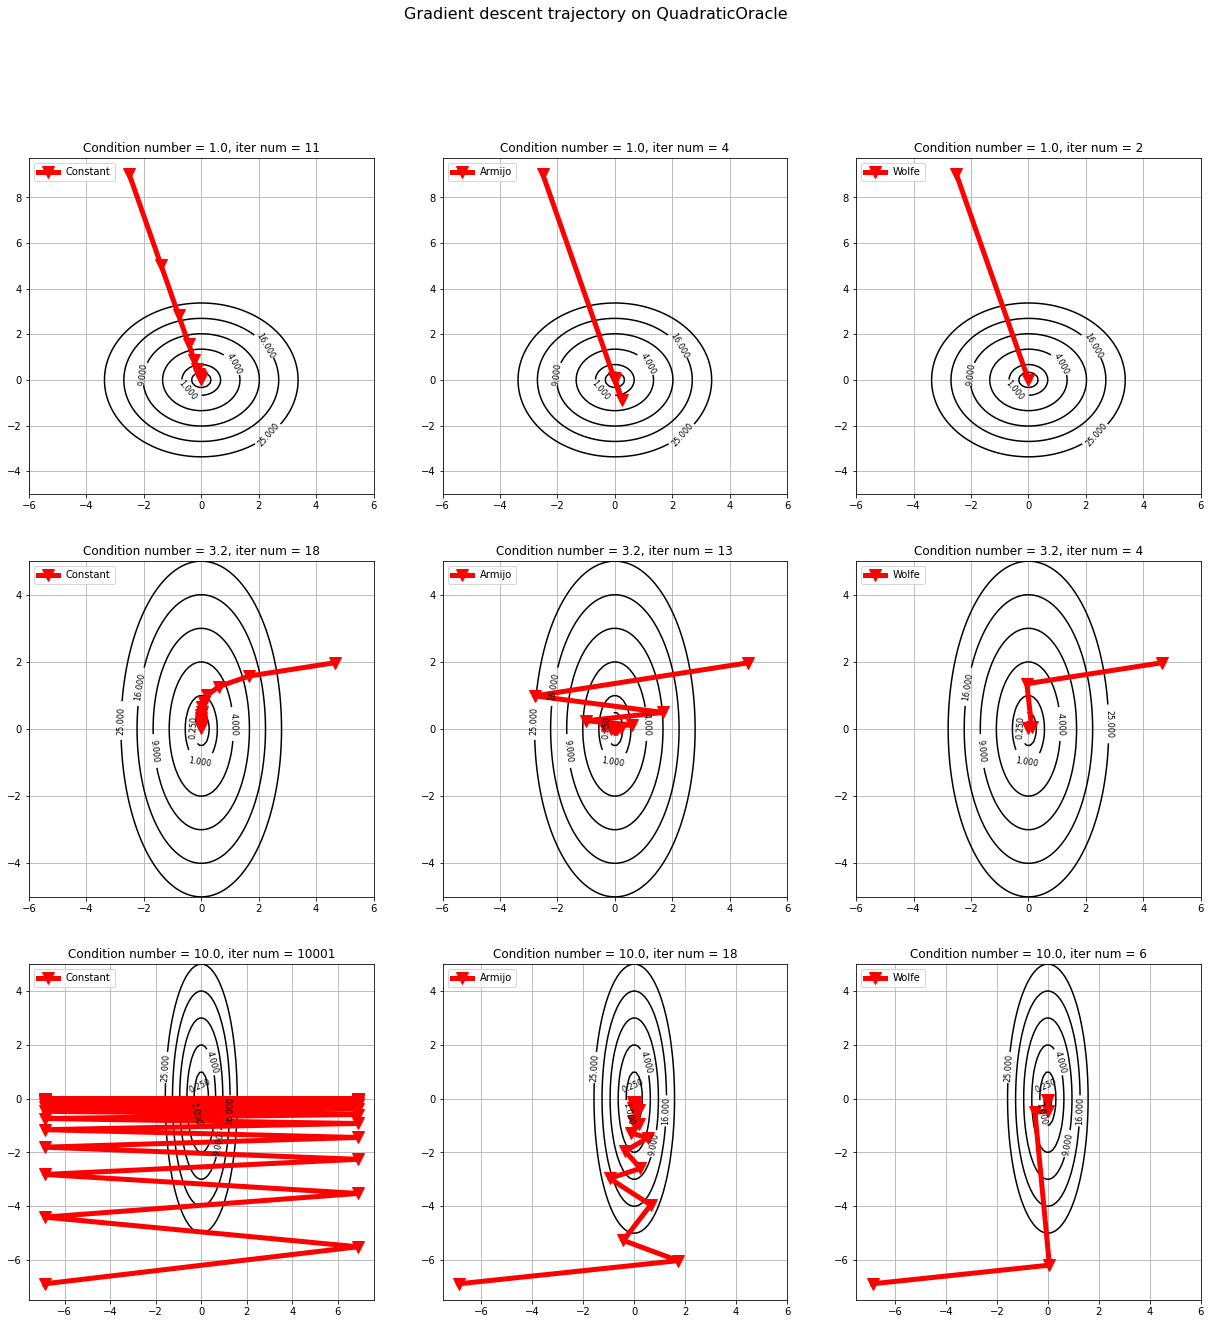

In [79]:
np.random.seed(42)
A_1 = np.array([[4.4, 0], [0, 4.4]])
A_2 = np.array([[6.4, 0], [0, 2]])
A_3 = np.array([[20, 0], [0, 2]])

matrixes = [A_1, A_2, A_3]
methods = ['Constant', 'Armijo', 'Wolfe']

b = np.zeros(2)

plt.figure(figsize=(21, 21))
plt.suptitle("Gradient descent trajectory on QuadraticOracle", fontsize=16)

for i, matrix in enumerate(matrixes):
    oracle = oracles.QuadraticOracle(matrix, b)
    x_0 = np.random.uniform(-10, 10, size=2) 
    cond_number = np.linalg.cond(matrix)
    
    for j, method in enumerate(methods):
        param_dict = create_param_dict(method)
        x_star, _, history = optimization.gradient_descent(oracle, 
                                                           x_0, 
                                                           line_search_options=param_dict, 
                                                           trace=True) 
        
        plt.subplot(3, 3, 3 * i + j + 1)
        iter_num = len(history['x'])
        plt.title(f"Condition number = {cond_number}, iter num = {iter_num}")
        plot_trajectory_2d.plot_levels(oracle.func)
        plot_trajectory_2d.plot_trajectory(oracle.func, history=history['x'], label=method)
        plt.legend(loc=2)

### Вывод:
По графикам видно, что $\forall \kappa$ количество итераций, необходимых для сходимости константному алгоритму поиска значитетельно больше, чем адаптивным алгоритмам поиска. Он показывает себя неплохо при небольшом числе обусловленности матрицы, но требует сильно больше итераций в противном случае. Лучше всего себя показывают алгоритмы Армихо и Вульфа, так же стоит заметить, что алгоритму Вульфа нужно меньше всего итераций, чтобы достигнуть сходимости. Кроме этого, можно заметить, что при увеличении числа обусловленности алгоритмы делают больше небольших шагов, что является неверным наблюдением для небольшого числа обусловленности матрицы. 

## Зависимость числа итераций градиентного спуска от чис- ла обусловленности и размерности пространства

In [93]:
def create_kappa_diag(highest_kappa):
    diag = np.random.uniform(low=1, high=kappa, size=n)
    diag[0], diag[-1] = 1, kappa
    return  scipy.sparse.diags(diag).toarray()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

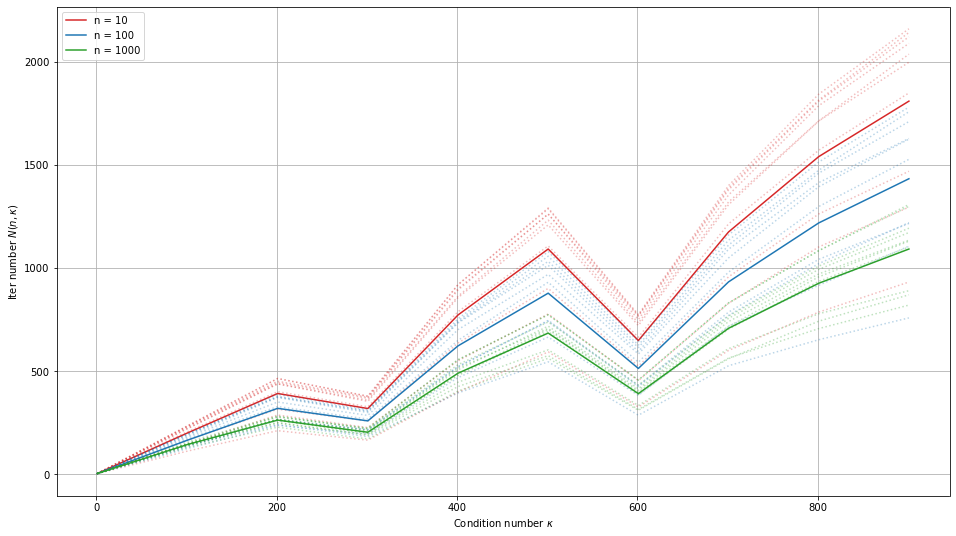

In [102]:
dim_sizes = [10, 100, 1000]
colors = ['tab:red', 'tab:blue', 'tab:green']
kappas = np.arange(1, 1000, 100)

plt.figure(figsize=(16, 9))
line_search_options = create_param_dict("Armijo")

resampling_rate = 10
for n, color in zip(dim_sizes, colors):
    iter_num_n = []
    with tqdm(total=resampling_rate) as pbar:
        for i in range(resampling_rate):
            iter_num_sample = []
            for kappa in kappas:
                np.random.seed(i)
                A = create_kappa_diag(kappa)
                b = np.random.uniform(low=1, high=kappa, size=n)
                oracle = oracles.QuadraticOracle(A, b)
                _, _, history = optimization.gradient_descent(oracle,
                                                              np.zeros(n),
                                                              line_search_options=line_search_options,
                                                              trace=True)
                iter_num_sample.append(len(history['func']))

            iter_num_n.append(iter_num_sample)  

            plt.plot(kappas, iter_num_sample, color=color, alpha=0.3, linestyle = 'dotted')
            
            pbar.set_description()
            pbar.update(1)
            
        plt.plot(kappas, np.mean(iter_num_n, axis=0), color=color, label='n = {}'.format(n))


plt.legend(loc=2)
plt.grid()
plt.ylabel('Iter number $N(n, \kappa)$')
plt.xlabel('Condition number $\kappa$')
plt.show()

### Вывод:
Зависимость роста количества итераций при увеличии числа обособленности похожа на линейную, что согласовывается с теоретическими выводами. Что касается размерности пространства, то явной зависимости не наблюдается, потому что по графику отчетливо видно, что характер каждой из кривых для одной размерности похож на остальные.

## Сравнение методов градиентного спуска и Ньютона на реальной задаче логистической регрессии

In [112]:
from sklearn.datasets import load_svmlight_file

def preprocess_data(name):
    X, y = load_svmlight_file(name)
    return X, y

In [172]:
def plot_learning_curve(histories, methods, dataset):
    plt.figure(figsize=(20, 20))
    
    plt.suptitle(f"LogReg with Armijo and Wolfe methods on {dataset}", fontsize=16)
    
    for i, method in enumerate(methods):
        plt.subplot(2, 2, i + 1)
        plt.title(f"{method} linesearch")
        
        plt.plot(histories['grad_descent'][method]['time'], histories['grad_descent'][method]['func'], label='grad_descent')
        plt.plot(histories['newton'][method]['time'], histories['newton'][method]['func'], label='newton')
        
        plt.xlabel('time, ms', fontsize=14)
        plt.ylabel('func', fontsize=14)
        plt.grid(ls=":")
        plt.legend(loc=2)
        
    for i, method in enumerate(methods):
        plt.subplot(2, 2, i + 3)
        
        plt.title(f"{method} linesearch")
        relative_grad_norm_gd = histories['grad_descent'][method]['grad_norm'] / histories['grad_descent'][method]['grad_norm'][0]
        relative_grad_norm_newton = histories['newton'][method]['grad_norm'] / histories['newton'][method]['grad_norm'][0]
        
        plt.plot(histories['grad_descent'][method]['time'], relative_grad_norm_gd, label='grad_descent')
        plt.plot(histories['newton'][method]['time'], relative_grad_norm_newton, label="newton")
        
        plt.grid(ls=":")
        plt.xlabel('time, ms', fontsize=14)
        plt.ylabel(r'$\frac{||\nabla f(x_k)||_2^2}{||\nabla f(x_0)||_2^2}$', fontsize=14)
        plt.yscale("log")
        plt.legend(loc=2)

    plt.show()

In [159]:
def train(oracle, x0):
    methods = ['Armijo', 'Wolfe']
    histories = {
        'grad_descent' : dict(),
        'newton' : dict()
    }

    for method in methods:
        _, _, history = optimization.gradient_descent(oracle, 
                                                      x_0,
                                                      line_search_options=create_param_dict(method),
                                                      trace=True
                                                     )
        histories['grad_descent'][method] = history
    
    for method in methods:
        _, _, history = optimization.newton(oracle, 
                                            x_0,
                                            line_search_options=create_param_dict(method),
                                            trace=True
                                            )
        histories['newton'][method] = history
    
    return histories

### w8a dataset

In [115]:
X, y = preprocess_data("data/w8a")
m, n = X.shape
oracle = oracles.create_log_reg_oracle(X, y, 1 / m)
x_0 = np.zeros(n)

In [160]:
histories = train(oracle, x_0)

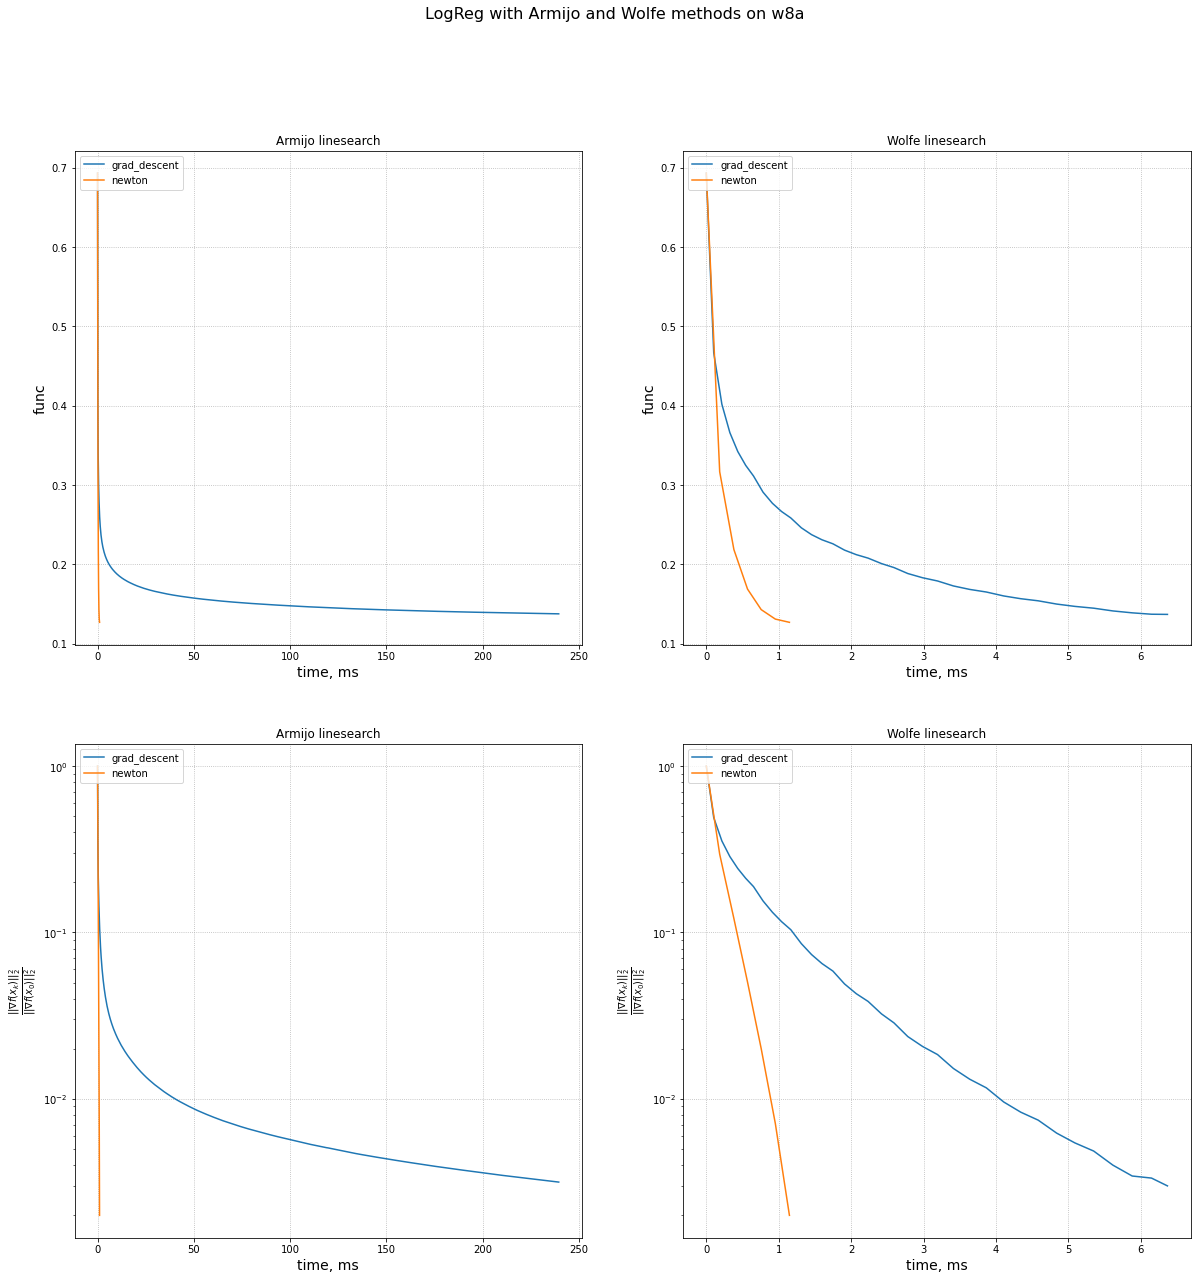

In [173]:
plot_learning_curve(histories, methods, "w8a")

### gisette dataset

In [174]:
X, y = preprocess_data("data/gisette_scale.bz2")
m, n = X.shape
oracle = oracles.create_log_reg_oracle(X, y, 1 / m)
x_0 = np.zeros(n)

In [175]:
histories = train(oracle, x_0)

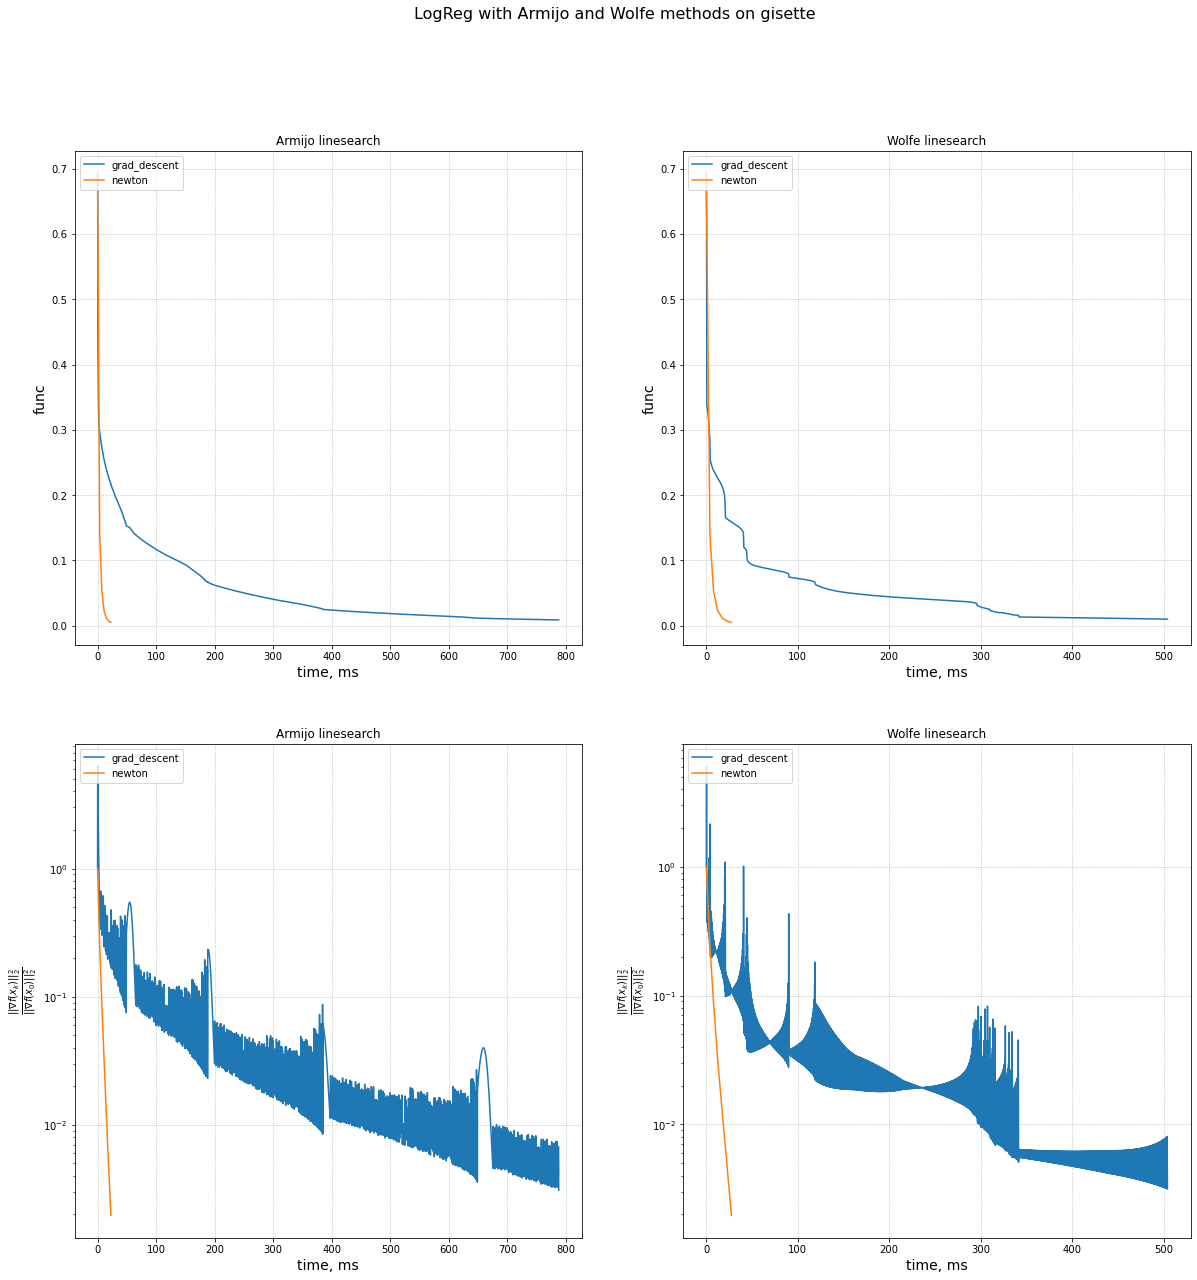

In [176]:
plot_learning_curve(histories, methods, "gisette")

### real-sim dataset

In [177]:
X, y = preprocess_data("data/real-sim.bz2")
m, n = X.shape
oracle = oracles.create_log_reg_oracle(X, y, 1 / m)
x_0 = np.zeros(n)

In [ ]:
histories = train(oracle, x_0)

In [ ]:
plot_learning_curve(histories, methods, "real-sim")